In [3]:
import numpy as np
from matplotlib import pyplot as plt
import openmc

import openmc.mgxs as mgxs
import pandas as pdF
#import moltres

In [4]:
#energy_groups = [0.025,1.0,14e6]

#energy_groups = [0.11,0.18,0.3,0.5,0.825,1.35,2.225,3.668]
energy_groups = [0.0,1e-6,10.0]
energy_groups = np.asarray(energy_groups) * 1e6

r_a = 3.44   #cm
r_b = 10   #cm


num_threads = 16

batches = 200
num_inactive = 20
num_particles = 50000

In [5]:
#Material Properties
plutonium = openmc.Material(name="plutonium")
plutonium.add_nuclide('Pu239',1.0,'ao')
plutonium.set_density('g/cm3',15.7)

beryllium = openmc.Material(name="beryllium")
beryllium.add_element('Be',1.0)
#beryllium.add_s_alpha_beta("c_Be")
beryllium.set_density('g/cm3',1.85)

materials = openmc.Materials([plutonium,beryllium])
materials.export_to_xml()

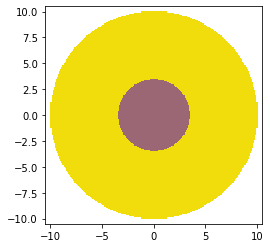

In [6]:
#Set sphere geometry and create sphere cell
sphere_geometry = openmc.Sphere(r=r_a)
inside_sphere = -sphere_geometry
outside_sphere = +sphere_geometry

shell_geometry = openmc.Sphere(r=r_b,boundary_type='vacuum')

reflector_region = -shell_geometry & outside_sphere

sphere_cell = openmc.Cell(region = inside_sphere,
                  fill = plutonium)

reflector_cell = openmc.Cell(region=reflector_region,fill=beryllium)


universe = openmc.Universe(cells=[sphere_cell,reflector_cell])
#universe.add_cell(sphere_cell)

geometry = openmc.Geometry()
geometry.root_universe = universe
geometry.export_to_xml()
geom = geometry

#Plot cell
size = (r_b) * 2.1
universe.plot(width=(size,size))
universe.plot(width=(size,size),basis="xz")
plt.show(universe.plot)

In [7]:
settings = openmc.Settings()

settings.batches = batches
settings.inactive = num_inactive
settings.particles = num_particles
settings.temperature = {"multipole": True, "method": "interpolation"}
point = openmc.stats.Point((0, 0, 0))
src = openmc.Source(space=point)
settings.source = src
settings.export_to_xml()

tallies_file = openmc.Tallies()

In [8]:
delayed_groups = list(range(1, 7))
domains = [sphere_cell,reflector_cell]
domain_ids = [sphere_cell.id,reflector_cell.id]

groups = mgxs.EnergyGroups()
groups.group_edges = np.array(energy_groups)
big_group = mgxs.EnergyGroups()
big_energy_group = [energy_groups[0], energy_groups[-1]]
big_group.group_edges = np.array(big_energy_group)
energy_filter = openmc.EnergyFilter(energy_groups)
domain_dict = {}

for id in domain_ids:
    domain_dict[id] = {}

for domain, id in zip(domains, domain_ids):
    domain_dict[id]["beta"] = mgxs.Beta(
        domain=domain,
        energy_groups=big_group,
        delayed_groups=delayed_groups,
        name=str(id) + "_beta",
    )
    domain_dict[id]["chi"] = mgxs.Chi(
        domain=domain, groups=groups, name=str(id) + "_chi"
    )
    domain_dict[id]["chiprompt"] = mgxs.Chi(
        domain=domain, groups=groups,
        name=str(id) + "_chiprompt", prompt=True)
    domain_dict[id]["chidelayed"] = mgxs.ChiDelayed(
        domain=domain, energy_groups=groups,
        name=str(id) + "_chidelayed")
    domain_dict[id]["decayrate"] = mgxs.DecayRate(
        domain=domain,
        energy_groups=big_group,
        delayed_groups=delayed_groups,
        name=str(id) + "_decayrate",
    )
    domain_dict[id]["diffusioncoefficient"] = \
        mgxs.DiffusionCoefficient(
        domain=domain,
        groups=groups,
        name=str(id) +
        "_diffusioncoefficient",
    )
    domain_dict[id]["scatterprobmatrix"] = \
        mgxs.ScatterProbabilityMatrix(
        domain=domain, groups=groups,
        name=str(id) + "_scatterprobmatrix"
    )
    domain_dict[id]["scatterxs"] = mgxs.ScatterXS(
        domain=domain, groups=groups,
        name=str(id) + "_scatterxs", nu=True)
    domain_dict[id]["inversevelocity"] = mgxs.InverseVelocity(
        domain=domain, groups=groups, name=str(id) + "_inversevelocity"
    )
    domain_dict[id]["fissionxs"] = mgxs.FissionXS(
        domain=domain, groups=groups, name=str(id) + "_fissionxs",
        nu=True
    )
    domain_dict[id]["fissionxs_nonu"] = mgxs.FissionXS(
        domain=domain, groups=groups, name=str(id) + "_fissionxs_nonu",
    )
    domain_dict[id]["kappafissionxs"] = mgxs.KappaFissionXS(
        domain=domain, groups=groups, name=str(id) + "_kappafissionxs"
    )
    domain_dict[id]["absorptionxs"] = mgxs.AbsorptionXS(
        domain=domain, groups=groups, name=str(id) + "_absorptionxs"
    )
    domain_dict[id]["scattermatrixxs"] = mgxs.ScatterMatrixXS(
        domain=domain, groups=groups, name=str(id) + "_scattermatrixxs",
        nu=True
    )
    domain_dict[id]["nufissionmatrixxs"] = mgxs.NuFissionMatrixXS(
        domain=domain, groups=groups, name=str(id) + "_nufissionmatrixxs"
    )
    domain_dict[id]["tally"] = openmc.Tally(name=str(id) + " tally")
    if isinstance(domain, openmc.Material):
        domain_dict[id]["filter"] = openmc.MaterialFilter(domain)
    elif isinstance(domain, openmc.Cell):
        domain_dict[id]["filter"] = openmc.CellFilter(domain)
    else:
        domain_dict[id]["filter"] = openmc.MeshFilter(domain)
    domain_dict[id]["tally"].filters = [
        domain_dict[id]["filter"],
        energy_filter,
    ]
    domain_dict[id]["tally"].scores = [
        "nu-fission",
        "flux",
    ]
    
    tallies_file += domain_dict[id]["beta"].tallies.values()
    tallies_file += domain_dict[id]["chi"].tallies.values()
    tallies_file += domain_dict[id]["chiprompt"].tallies.values()
    tallies_file += domain_dict[id]["chidelayed"].tallies.values()
    tallies_file += domain_dict[id]["decayrate"].tallies.values()
    tallies_file += domain_dict[id]["diffusioncoefficient"] \
        .tallies.values()
    tallies_file += domain_dict[id]["scatterprobmatrix"] \
        .tallies.values()
    tallies_file += domain_dict[id]["scatterxs"].tallies.values()
    tallies_file += domain_dict[id]["inversevelocity"].tallies.values()
    tallies_file += domain_dict[id]["fissionxs"].tallies.values()
    tallies_file += domain_dict[id]["kappafissionxs"].tallies.values()
    tallies_file += domain_dict[id]["absorptionxs"].tallies.values()
    tallies_file += domain_dict[id]["scattermatrixxs"].tallies.values()
    tallies_file += domain_dict[id]["nufissionmatrixxs"].tallies.values()
    tallies_file += domain_dict[id]["fissionxs_nonu"].tallies.values()
    tallies_file.append(domain_dict[id]["tally"])
tallies_file.export_to_xml()

/home/andrew/miniconda3/envs/openmc/lib/python3.10/site-packages/openmc/mixin.py:67: IDWarning: Another Filter instance already exists with id=3.
  warn(msg, IDWarning)
/home/andrew/miniconda3/envs/openmc/lib/python3.10/site-packages/openmc/mixin.py:67: IDWarning: Another Filter instance already exists with id=4.
  warn(msg, IDWarning)
/home/andrew/miniconda3/envs/openmc/lib/python3.10/site-packages/openmc/mixin.py:67: IDWarning: Another Filter instance already exists with id=7.
  warn(msg, IDWarning)
/home/andrew/miniconda3/envs/openmc/lib/python3.10/site-packages/openmc/mixin.py:67: IDWarning: Another Filter instance already exists with id=5.
  warn(msg, IDWarning)
/home/andrew/miniconda3/envs/openmc/lib/python3.10/site-packages/openmc/mixin.py:67: IDWarning: Another Filter instance already exists with id=18.
  warn(msg, IDWarning)
/home/andrew/miniconda3/envs/openmc/lib/python3.10/site-packages/openmc/mixin.py:67: IDWarning: Another Filter instance already exists with id=20.
  warn(

In [9]:
#Run simulation
openmc.run(threads=num_threads)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [10]:
#summary = openmc.Summary("summary.h5")
statepoint_name = "statepoint." + str(batches) + ".h5"
sp = openmc.StatePoint(statepoint_name)

filters = sp.filters

diff_coeff_list = []
downscatter_xs_list = []
fission_xs_list = []

for i,domain_id in enumerate(domain_ids):
    print("#"*60)
    print(domains[i].fill,'\n')
    print("#"*60,'\n')
    
    prob_matrix = domain_dict[domain_id]["scatterprobmatrix"]
    scatterxs = domain_dict[domain_id]["scatterxs"]
    scatter_matrix = domain_dict[domain_id]["scattermatrixxs"]
    diffusion_const = domain_dict[domain_id]["diffusioncoefficient"]
    fission = domain_dict[domain_id]["fissionxs"]
    fission_nonu = domain_dict[domain_id]["fissionxs_nonu"]
    nu_fission = domain_dict[domain_id]["nufissionmatrixxs"]
    abs_matrix = nu_fission = domain_dict[domain_id]["absorptionxs"]

    prob_matrix.load_from_statepoint(sp)
    scatterxs.load_from_statepoint(sp)
    scatter_matrix.load_from_statepoint(sp)
    diffusion_const.load_from_statepoint(sp)
    fission.load_from_statepoint(sp)
    nu_fission.load_from_statepoint(sp)
    fission_nonu.load_from_statepoint(sp)
    abs_matrix.load_from_statepoint(sp)

    scatterxs_df = scatterxs.get_pandas_dataframe()
    prob_matrix_df = prob_matrix.get_pandas_dataframe()
    scatter_matrix_df = scatter_matrix.get_pandas_dataframe()
    diffusion_const_df =diffusion_const.get_pandas_dataframe()
    fission_df = fission.get_pandas_dataframe()
    nu_fission_df = nu_fission.get_pandas_dataframe()
    fission_nonu_df = fission_nonu.get_pandas_dataframe()
    abs_matrix_df = abs_matrix.get_pandas_dataframe()

    print(scatter_matrix.print_xs())
    print(diffusion_const.print_xs())
    print(fission_nonu.print_xs())
    print(fission.print_xs())
    print(nu_fission.print_xs())
    print(nu_fission.xs_tally.scores)
    print(abs_matrix.print_xs())
    
    #display(nu_fission_df)

    domain_diff_list = []
    domain_downscatter_list = []
    fission_domain_list = []
    for j in range(len(groups.group_edges)-1):
        domain_diff_list.append(diffusion_const_df["mean"][j])
        fission_domain_list.append(fission_df["mean"][j])
    domain_diff_list.reverse()
    fission_domain_list.reverse()
    diff_coeff_list.append(domain_diff_list)
    fission_xs_list.append(fission_domain_list)
    
    for groupIn in scatter_matrix_df["group in"]:
        domain_downscatter_list.append(np.array(scatter_matrix_df.loc[scatter_matrix_df["group in"] == groupIn]["mean"]))
    downscatter_xs_list.append(domain_downscatter_list)
    
    print("*"*100)
    
sp.close()
print(diff_coeff_list)
print(downscatter_xs_list)
print(fission_xs_list)

#Downscatter list in form downscatter_xs_list[domain number][energy group number - 1][out energy group number - 1]

/home/andrew/miniconda3/envs/openmc/lib/python3.10/site-packages/openmc/mixin.py:67: IDWarning: Another Filter instance already exists with id=18.
  warn(msg, IDWarning)
/home/andrew/miniconda3/envs/openmc/lib/python3.10/site-packages/openmc/mixin.py:67: IDWarning: Another Filter instance already exists with id=20.
  warn(msg, IDWarning)
/home/andrew/miniconda3/envs/openmc/lib/python3.10/site-packages/openmc/mixin.py:67: IDWarning: Another Filter instance already exists with id=3.
  warn(msg, IDWarning)
/home/andrew/miniconda3/envs/openmc/lib/python3.10/site-packages/openmc/mixin.py:67: IDWarning: Another Filter instance already exists with id=4.
  warn(msg, IDWarning)
/home/andrew/miniconda3/envs/openmc/lib/python3.10/site-packages/openmc/mixin.py:67: IDWarning: Another Filter instance already exists with id=44.
  warn(msg, IDWarning)
/home/andrew/miniconda3/envs/openmc/lib/python3.10/site-packages/openmc/mixin.py:67: IDWarning: Another Filter instance already exists with id=5.
  warn

############################################################
Material
	ID             =	1
	Name           =	plutonium
	Temperature    =	None
	Density        =	15.7 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	Pu239          =	1.0          [ao]
 

############################################################ 

Multi-Group XS
	Reaction Type  =	nu-scatter
	Domain Type    =	cell
	Domain ID      =	1
	Energy Groups: 
            Group 1 [1.0        - 10000000.0eV]
            Group 2 [0.0        - 1.0       eV]
	Nuclide        =	sum
	Cross Sections [cm^-1]:
            Group 1 -> Group 1:		1.74e-01 +/- 1.08e-01%
            Group 1 -> Group 2:		2.89e-07 +/- 3.26e+01%

            Group 2 -> Group 1:		1.16e-03 +/- 1.00e+02%
            Group 2 -> Group 2:		4.46e-01 +/- 6.43e+00%





None
Multi-Group XS
	Reaction Type  =	diffusion-coefficient
	Domain Type    =	cell
	Domain ID      =	1
	Cross Sections [cm^-1]:
            Group 1 [1.0        - 10000000.0eV]:	1.34e+00 +/- 7.92e-02%
            Gro

/home/andrew/miniconda3/envs/openmc/lib/python3.10/site-packages/openmc/tallies.py:1267: RuntimeWarning: invalid value encountered in true_divide
  data = self.std_dev[indices] / self.mean[indices]


In [11]:
diff_coeff_u1_c, diff_coeff_u2_c= diff_coeff_list[0][:]
diff_coeff_u1_m, diff_coeff_u2_m= diff_coeff_list[1][:]

sigma_s12_c, sigma_s12_m = downscatter_xs_list[0][0][1],downscatter_xs_list[1][0][1]

fiss_u1_c, fiss_u2_c = fission_xs_list[0][:]